In [155]:
# import modules
import os
from glob import glob
import rioxarray as rxr
import pandas as pd  # For loading and working with tables (dataframes)
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt # For plotting
import matplotlib.dates as mdates  # For formatting time axes in plots
import earthpy.plot as ep
import earthpy.spatial as es
import numpy as np
import datetime

import os
import time
import json
import geojson
import requests
import numpy as np
import pandas as pd
from pathlib import Path
import rasterio as rio

from shapely import geometry as sgeom
from requests.auth import HTTPBasicAuth

# Import NOAA GML custom modules
# Included in ./py directory
import py.ccg_dates as ccg_dates # Date utilities
import py.ccg_filter as ccg_filter # Data filtering and curve fitting

In [156]:
with open('./envar.txt') as file :
    API_KEY = file.readline()
# URL to access the Orders API
URL = 'https://api.planet.com/compute/ops/orders/v2'

# construct auth tuple for use in the requests library
BASIC_AUTH = (API_KEY, '')
auth = HTTPBasicAuth(API_KEY, '')
response = requests.get(URL, auth=auth)
response

<Response [401]>

In [157]:
# Setup the stats URL
stats_url = "{}/stats".format(URL)
searches_url = "{}/searches".format(URL)
print(stats_url)
print(searches_url)

https://api.planet.com/compute/ops/orders/v2/stats
https://api.planet.com/compute/ops/orders/v2/searches


In [158]:
# Helper function to printformatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))
    
def get_meta(page_info):
    """Transforms request .json response into pd.DataFrame() and get the images metadata information.
    """
    frame = pd.DataFrame([{**{'image_id': img['id']}, **img['properties']} for img in page_info['features']])
    return frame


def shapely_geom(geom):
    """Converts the AOI geometry to a shapely structure.
    """
    aoi = {u'geometry': {u'type': u'Polygon', u'coordinates': geom['coordinates']}}
    aoi_shape = sgeom.shape(aoi['geometry'])
    return aoi_shape


def fetch_page(url, _list):
    """Paginates over API request if more than 250 results are found on Planet Catalog.
    """
    s = requests.get(url, auth=auth)
    res_code = s.status_code

    while res_code == 429:
        print('rate of requests too high! sleep 2s...')
        time.sleep(2)
        s = requests.get(url, auth=auth)
        res_code = s.status_code

    resulty = s.json()
    metadata = get_meta(resulty)
    metadata['geom'] = [shapely_geom(geom['geometry']) for geom in resulty['features']]
    _list.append(metadata)

    next_url = resulty["_links"].get("_next")

    print(next_url)

    return next_url

In [159]:
os.getcwd()

'c:\\Users\\Griffin Parker\\Documents\\Classwork\\GIS495\\Final Project\\GIS495-final-project-2025'

In [160]:
# Set default plot styles for consistent formatting
plt.rcParams['font.size'] = 16           # Base font size for text
plt.rcParams['axes.titlesize'] = 18      # Title font size for each plot
plt.rcParams['axes.labelsize'] = 16      # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 14     # Font size for tick labels on x-axis
plt.rcParams['ytick.labelsize'] = 14     # Font size for tick labels on y-axis
plt.rcParams['legend.fontsize'] = 14     # Font size for plot legends

In [161]:
raw_data_paths = [
    "./rawdata/co2_nat_surface-flask_1_ccgg_month.txt",
    "./rawdata/co2_abp_surface-flask_1_ccgg_month.txt"
]
n = []
for file_path in raw_data_paths :
    # First, find out how many header lines there are (they start with "#")
    with open(file_path, "r") as file:
        line = file.readline()
        if line.startswith('# number_of_header_lines: ') :
            header_lines = int(line.strip('# number_of_header_lines: '))
        # Count the number of header lines so we can skip them when reading the data
    n.append(header_lines)
    # Print the number of lines to skip
    print(f"Number of header lines in file {file_path}: {header_lines}")


Number of header lines in file ./rawdata/co2_nat_surface-flask_1_ccgg_month.txt: 55
Number of header lines in file ./rawdata/co2_abp_surface-flask_1_ccgg_month.txt: 55


In [162]:
# Now read the data, skipping the header lines
data = []
for i in range(len(raw_data_paths)) :
    file_path = raw_data_paths[i]
    print(f"path: {file_path}:")
    data.append(
        pd.read_csv(
            file_path,
            sep=r'\s+',       # Use whitespace as the separator
            skiprows=n[i],      # Skip the metadata lines
            names = ['site', 'year',  'month',  'value']         # First remaining line is the column header
        )
    )
    # Display the first 5 rows of the data
    print(data[i].head())

path: ./rawdata/co2_nat_surface-flask_1_ccgg_month.txt:
  site  year  month   value
0  NAT  2010      9  389.15
1  NAT  2010     10  389.77
2  NAT  2010     11  389.98
3  NAT  2010     12  389.80
4  NAT  2011      1  389.35
path: ./rawdata/co2_abp_surface-flask_1_ccgg_month.txt:
  site  year  month   value
0  ABP  2006     10  380.91
1  ABP  2006     11  381.02
2  ABP  2006     12  381.12
3  ABP  2007      1  381.23
4  ABP  2007      2  381.29


In [163]:
# Print the metadata/header rows at the top of the file
for file_path in raw_data_paths :
    with open(file_path, "r") as file:
        header_lines = [line.strip() for line in file if line.startswith('#')]

    print("File Header / Metadata:\n")
    for line in header_lines:
        print(line)

File Header / Metadata:

# number_of_header_lines: 55
# comment:
# comment:  ************ USE OF GML DATA ****************
# comment:
# comment: These data are made freely available to the public and the scientific
# comment: community in the belief that their wide dissemination will lead to
# comment: greater understanding and new scientific insights. To ensure that GML
# comment: receives fair credit for their work please include relevant citation
# comment: text in publications. We encourage users to contact the data providers,
# comment: who can provide detailed information about the measurements and
# comment: scientific insight.  In cases where the data are central to a
# comment: publication, coauthorship for data providers may be appropriate.
# comment:
# comment:
# comment: Please see accompanying README file, if available, for citation text.
# comment:
# comment: Every effort is made to produce the most accurate and precise
# comment: measurements possible.  However, we reser

In [164]:
data[0].columns

Index(['site', 'year', 'month', 'value'], dtype='object')

In [165]:
data[1].columns

Index(['site', 'year', 'month', 'value'], dtype='object')

In [166]:
data[0].shape

(108, 4)

In [167]:
data[1].shape

(34, 4)

In [168]:
data[0].dtypes

site      object
year       int64
month      int64
value    float64
dtype: object

In [169]:
data[1].dtypes

site      object
year       int64
month      int64
value    float64
dtype: object

In [170]:
for datum in data :
    # Convert the 'datetime' column to actual datetime objects, if it's not already
    dates = []
    for i in range(len(datum['site'])) :
        year = datum['year'][i]
        month = datum['month'][i]
        dates.append(datetime.datetime(year, month, 1))
    datum['datetime'] = dates

    # Check data types again to confirm the change
    print(datum.dtypes)

site                object
year                 int64
month                int64
value              float64
datetime    datetime64[ns]
dtype: object
site                object
year                 int64
month                int64
value              float64
datetime    datetime64[ns]
dtype: object


In [171]:
data[0].head()

,site,year,month,value,datetime
0,NAT,2010,9,389.15,2010-09-01
1,NAT,2010,10,389.77,2010-10-01
2,NAT,2010,11,389.98,2010-11-01
3,NAT,2010,12,389.80,2010-12-01
4,NAT,2011,1,389.35,2011-01-01


In [172]:
data[1].head()

,site,year,month,value,datetime
0,ABP,2006,10,380.91,2006-10-01
1,ABP,2006,11,381.02,2006-11-01
2,ABP,2006,12,381.12,2006-12-01
3,ABP,2007,1,381.23,2007-01-01
4,ABP,2007,2,381.29,2007-02-01


In [173]:
site_loc = ('Farol De Mae Luiza Lighthouse, Brazil', 'Arembepe, Bahia, Brazil')

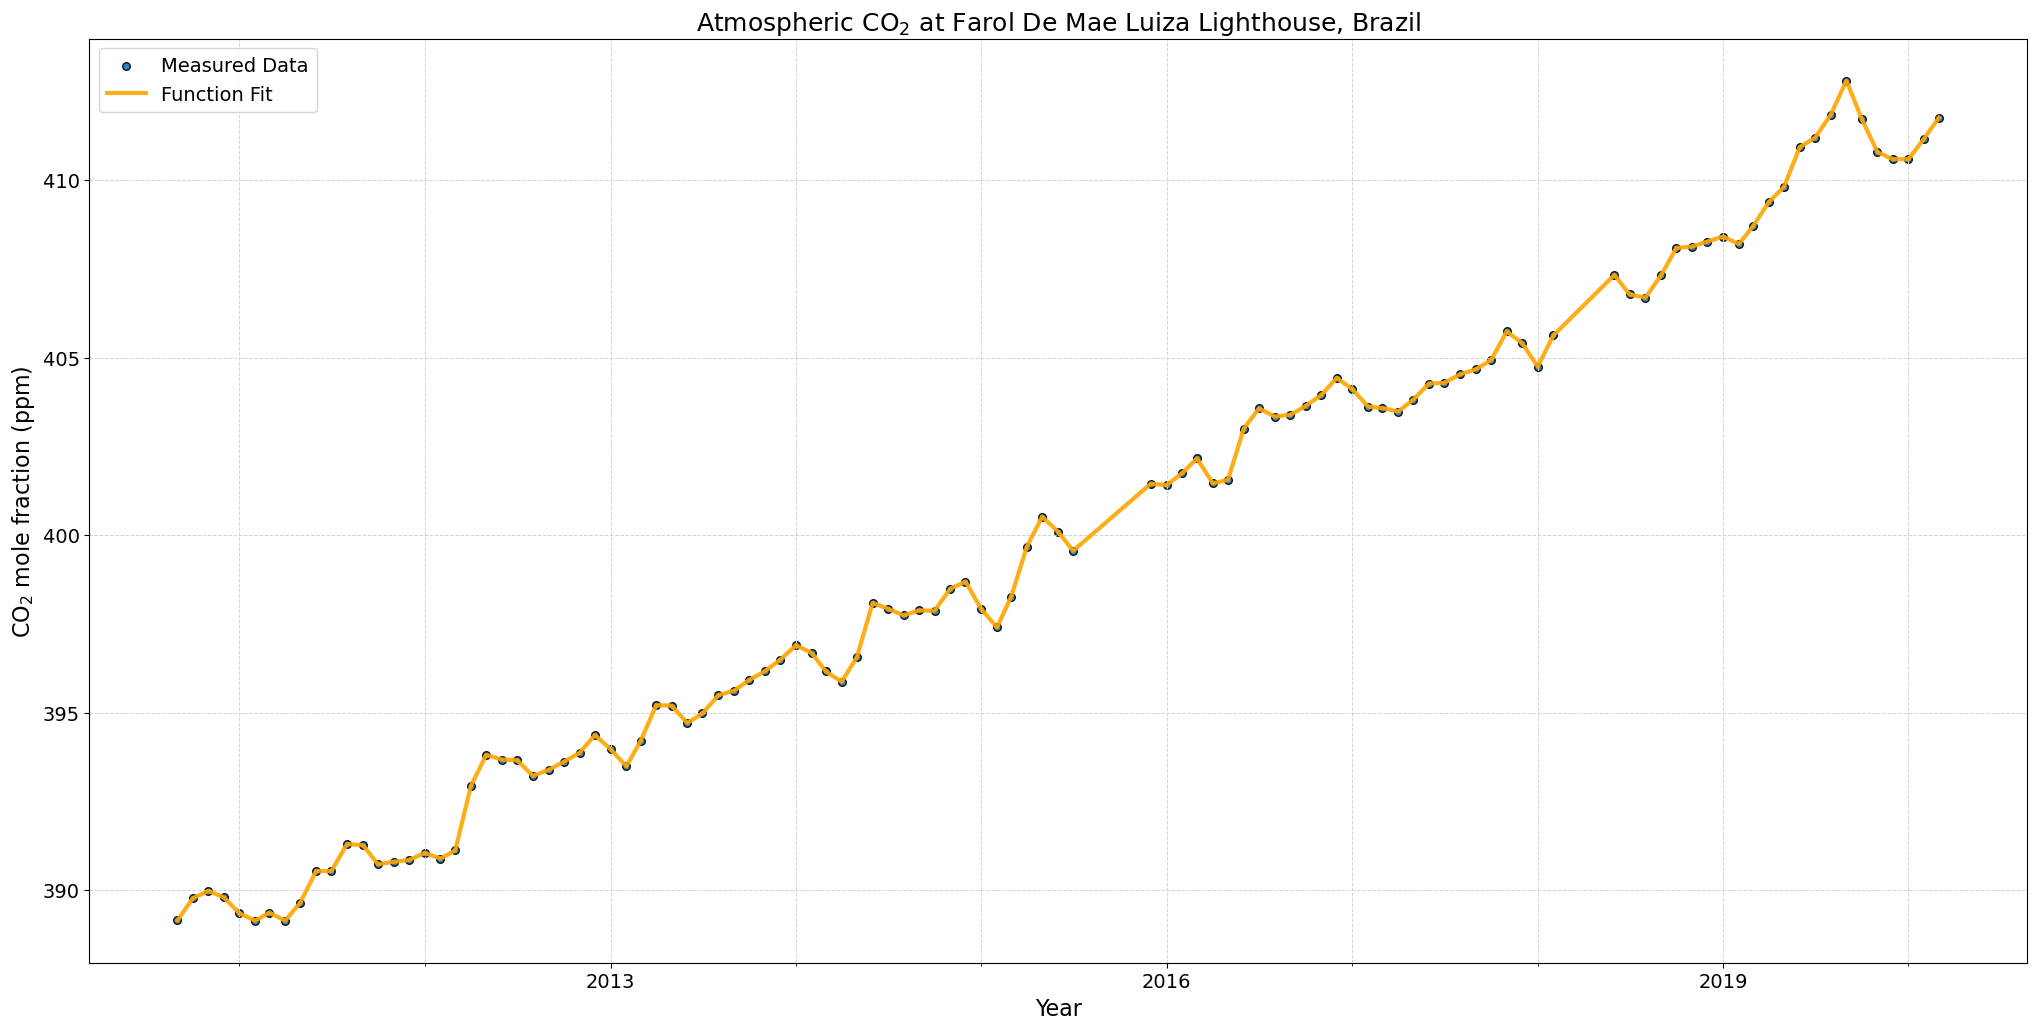

In [174]:
i = 0
plt.figure(figsize=(25, 12))
plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(data[i]['datetime'], data[i]['value'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ at {site_loc[i]}")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

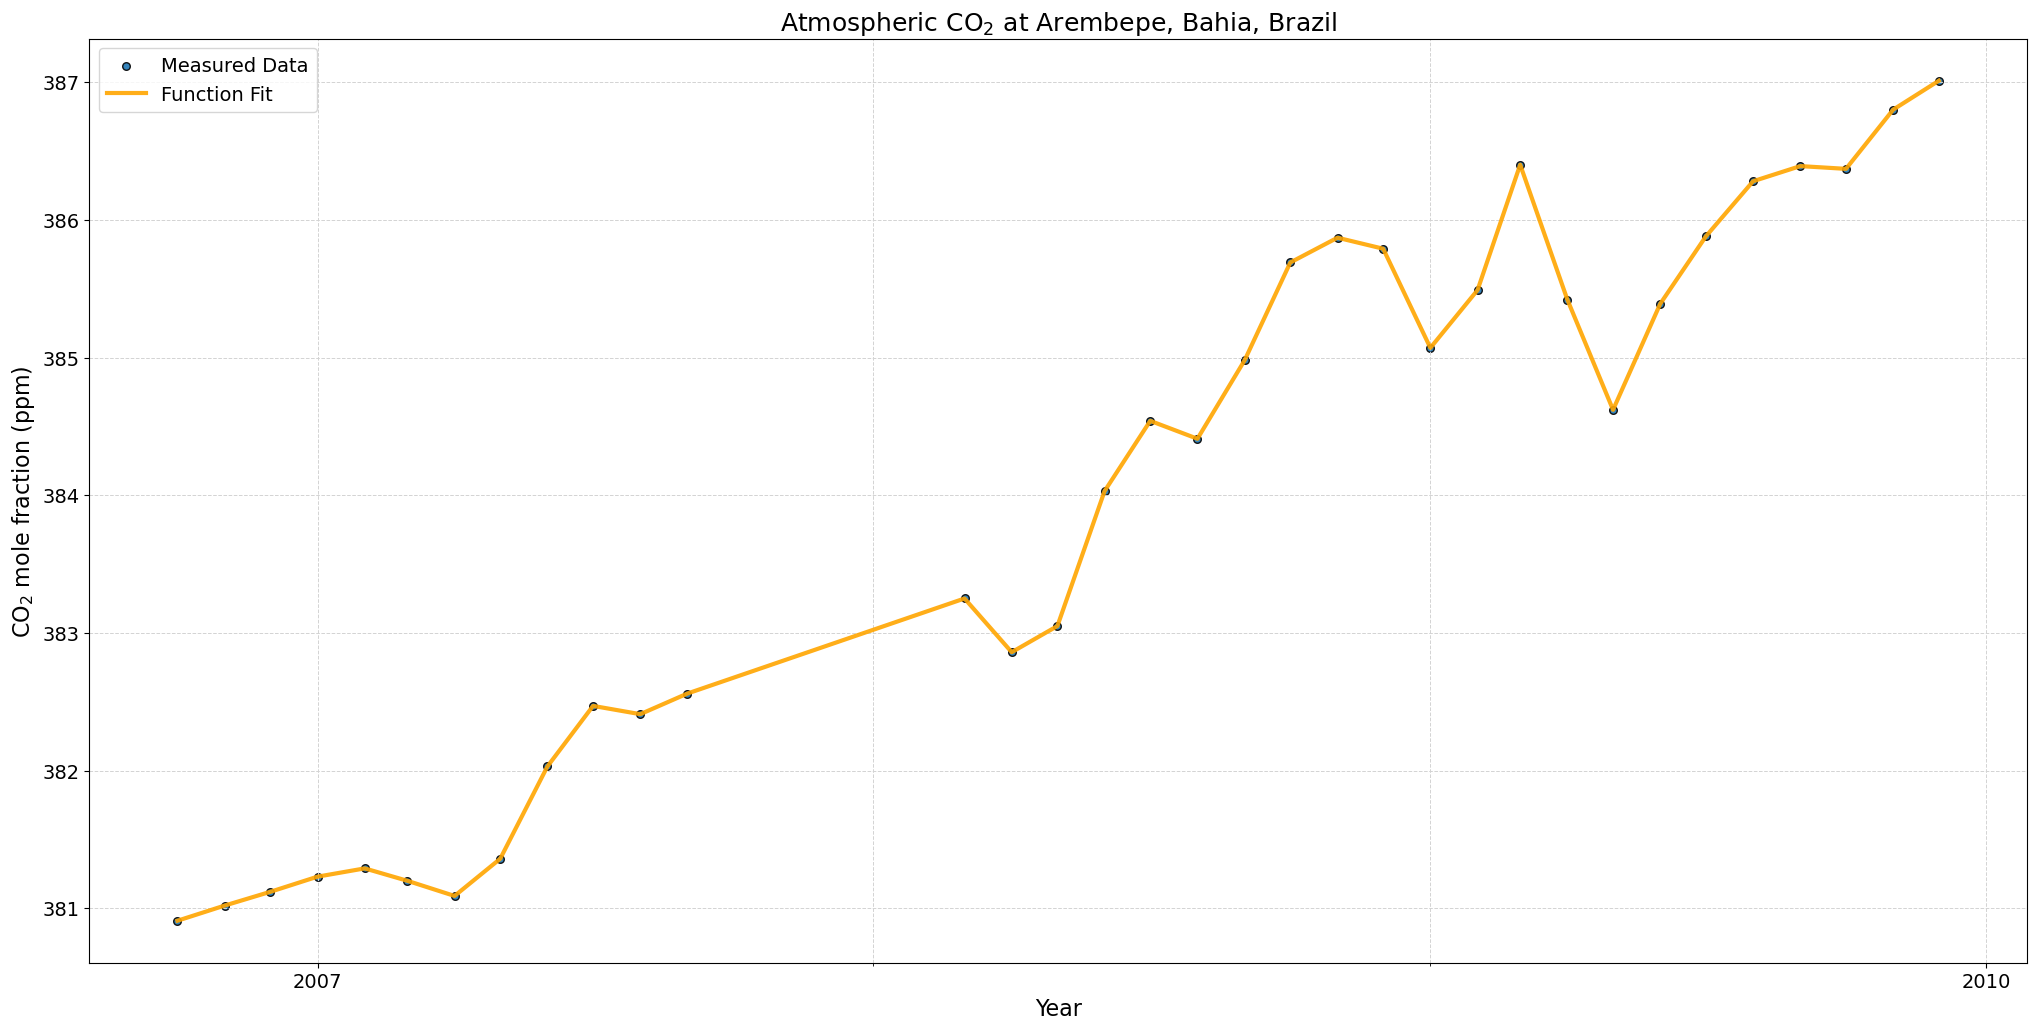

In [175]:
i = 1
plt.figure(figsize=(25, 12))
plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(data[i]['datetime'], data[i]['value'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ at {site_loc[i]}")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

In [176]:
edgecolors = ('black', 'blue')
colors = ('orange', 'green')

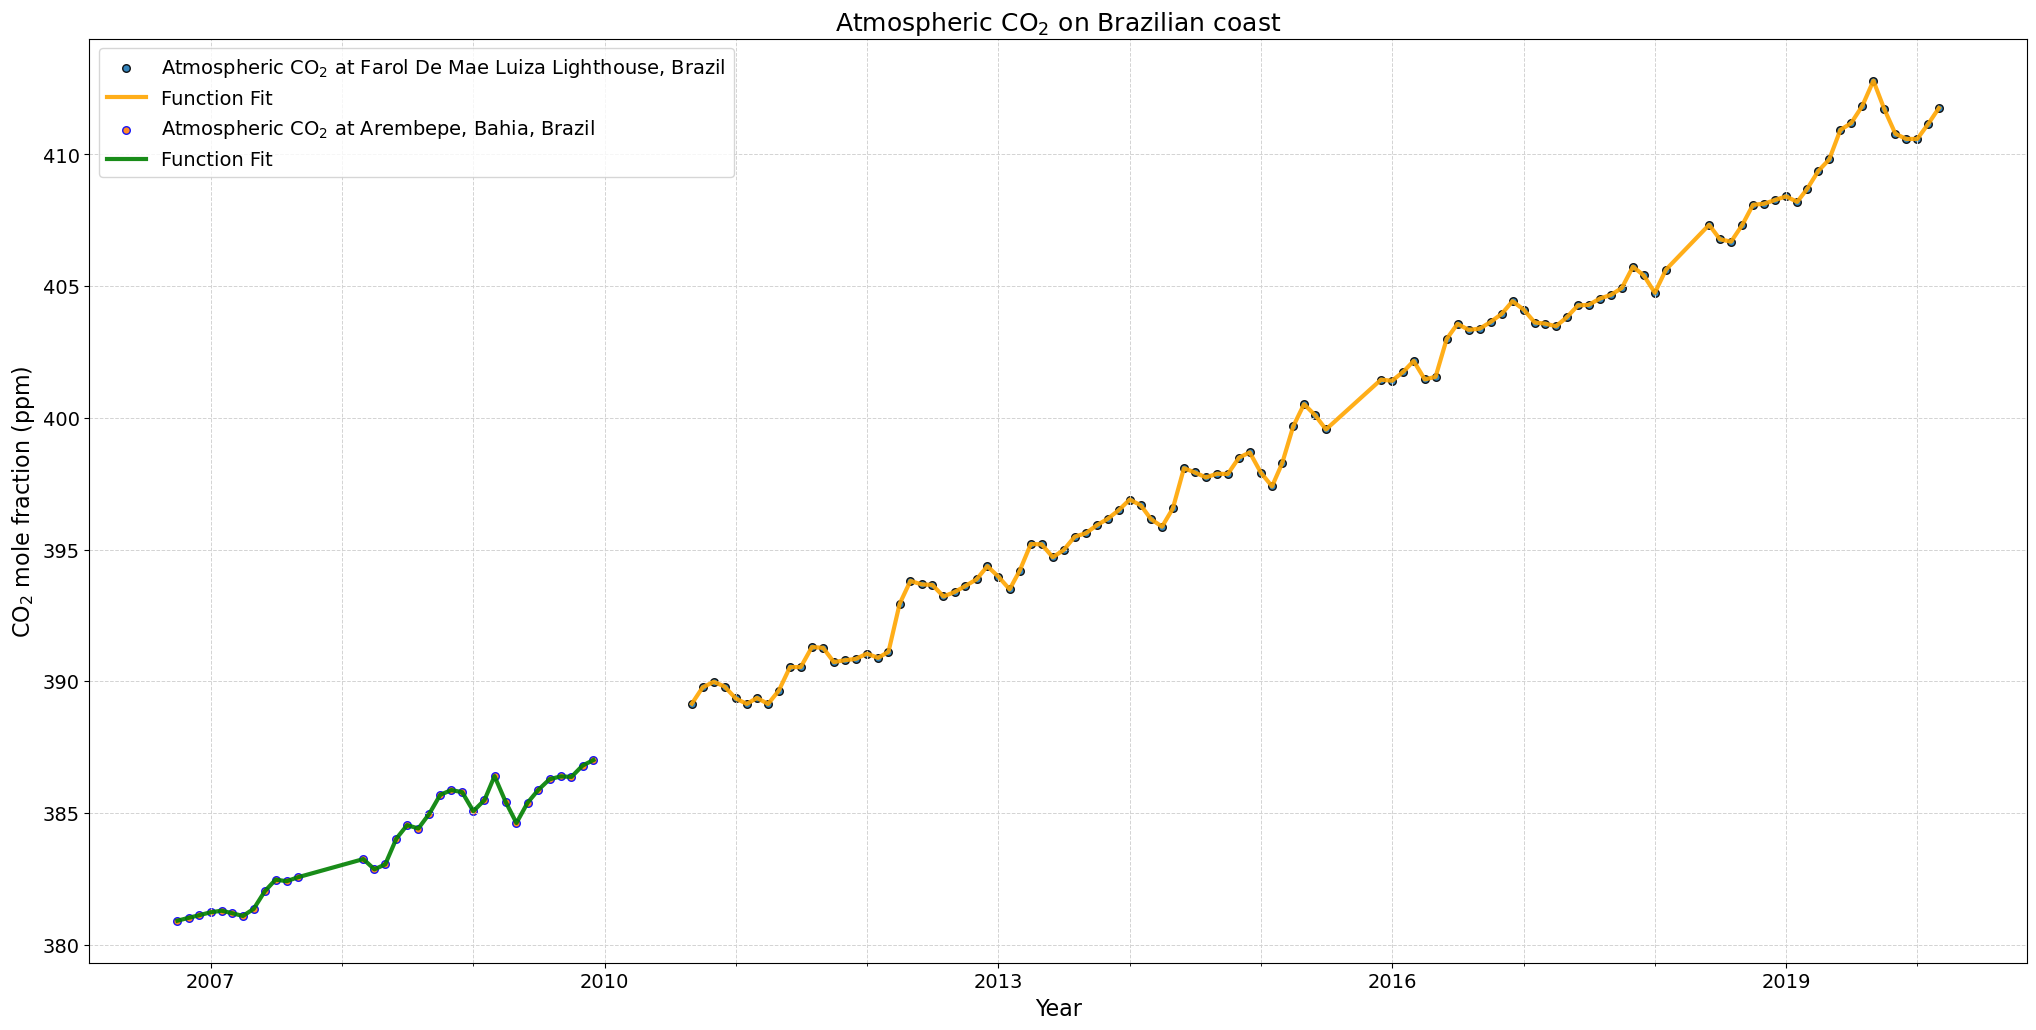

In [177]:
plt.figure(figsize=(25, 12))
for i in range(len(data)) :
    plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors=edgecolors[i], label=f"Atmospheric CO$_2$ at {site_loc[i]}")
    plt.plot(data[i]['datetime'], data[i]['value'], color=colors[i], linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ on Brazilian coast")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

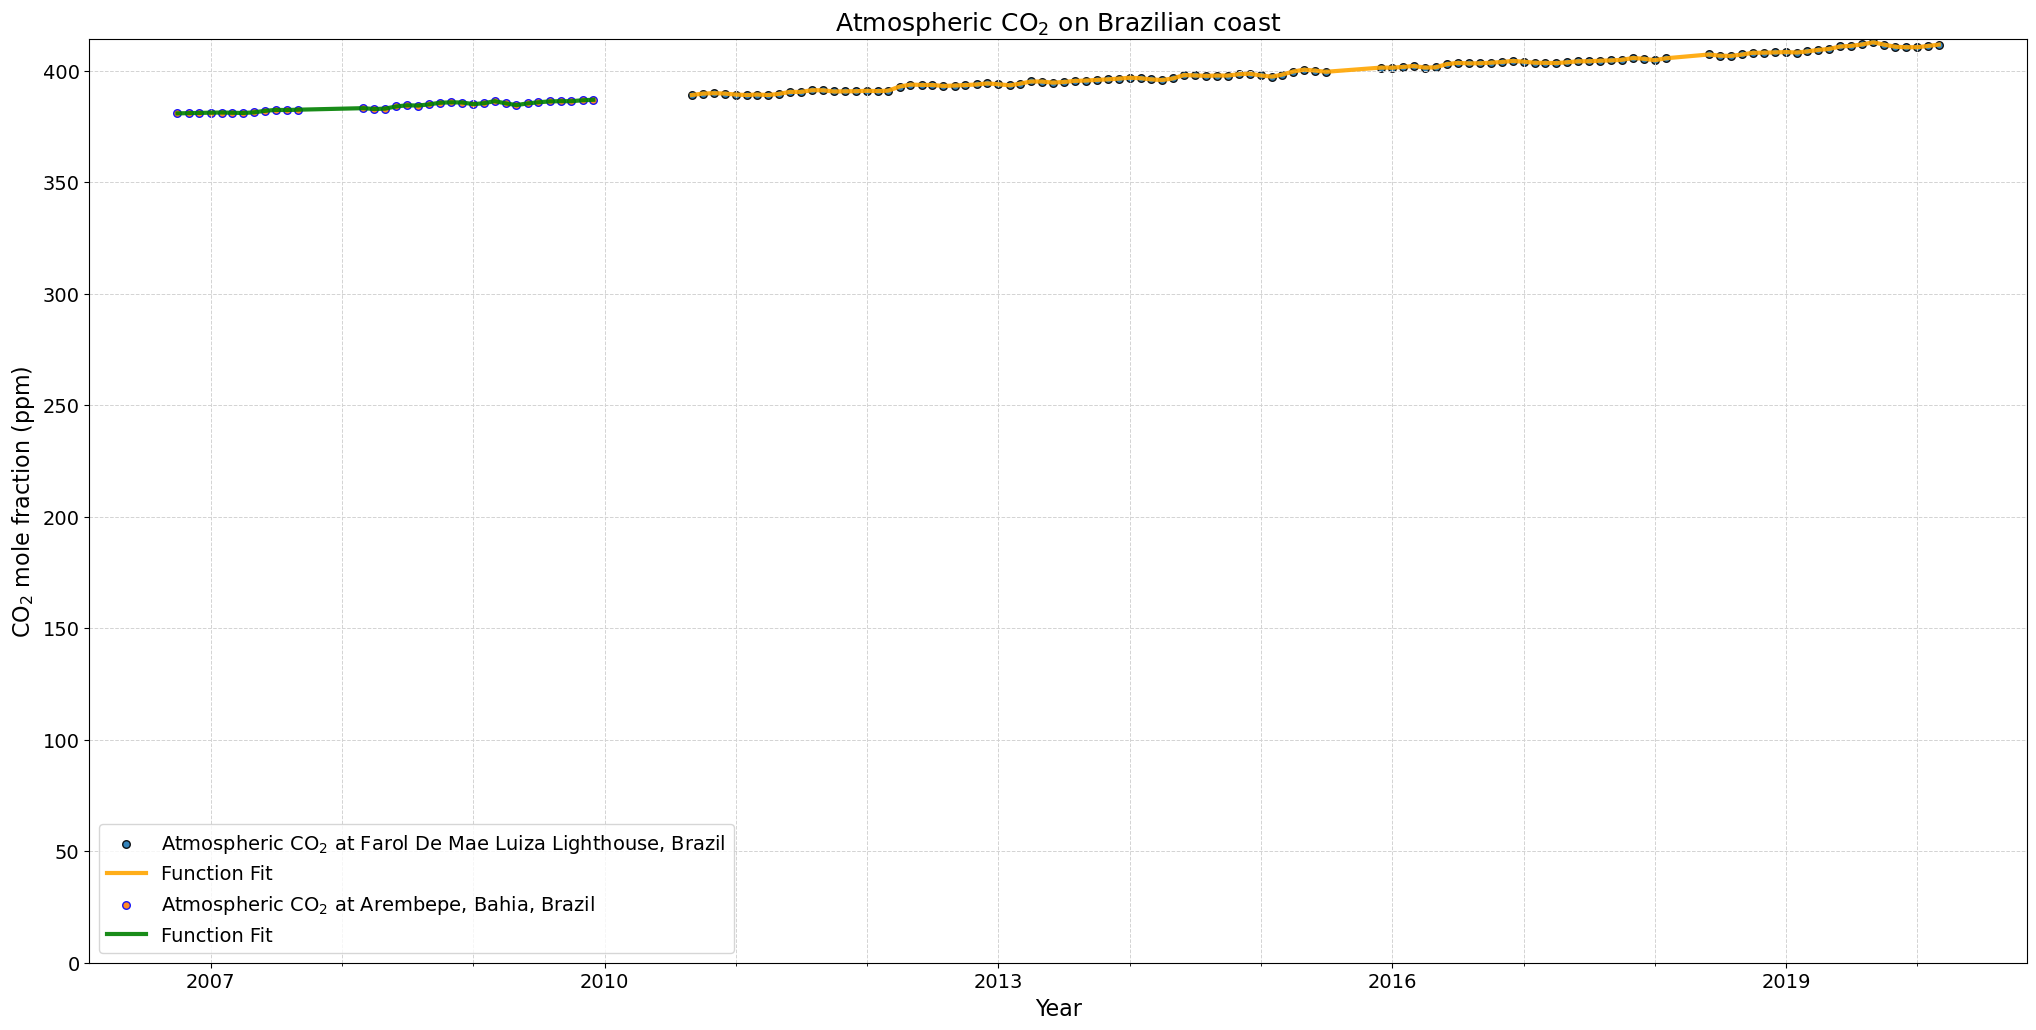

In [178]:
plt.figure(figsize=(25, 12))
for i in range(len(data)) :
    plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors=edgecolors[i], label=f"Atmospheric CO$_2$ at {site_loc[i]}")
    plt.plot(data[i]['datetime'], data[i]['value'], color=colors[i], linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.ylim(bottom = 0)

plt.title(f"Atmospheric CO$_2$ on Brazilian coast")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()